<a href="https://colab.research.google.com/github/SKashhh/Voyage-AI-Traveller-Segmentation/blob/main/VOYAGE_AI_TRAVELLER_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VOYAGE AI — SILHOUETTE OPTIMIZED CLUSTERING
## Silhouette 0.35–0.40 ✓ | 5,000 Users | 14 Features | K-Means vs GMM


## Step 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import IsolationForest
from scipy import stats
import joblib
import warnings
warnings.filterwarnings('ignore')

print('✓ All libraries imported successfully')

✓ All libraries imported successfully


## Step 2: Load & Clean Real Data



In [4]:
# Load raw Kaggle data
df_raw = pd.read_csv('Travel details dataset.csv')
print(f'✓ Loaded {len(df_raw)} real records')
print(f'  Columns: {df_raw.columns.tolist()}')

# FIX: only convert columns that should be numeric
df_raw['Accommodation cost']  = pd.to_numeric(df_raw['Accommodation cost'],  errors='coerce')
df_raw['Transportation cost'] = pd.to_numeric(df_raw['Transportation cost'], errors='coerce')

# Standardise inconsistent transport labels
df_raw['Transportation type'] = df_raw['Transportation type'].replace(
    {'Plane': 'Flight', 'Airplane': 'Flight'})

# Parse date → extract travel month
df_raw['Start date']   = pd.to_datetime(df_raw['Start date'], errors='coerce')
df_raw['travel_month'] = df_raw['Start date'].dt.month

# Fill non-critical categoricals (do NOT drop them as NaN)
df_raw['Accommodation type']  = df_raw['Accommodation type'].fillna('Hotel')
df_raw['Transportation type'] = df_raw['Transportation type'].fillna('Flight')
df_raw['Traveler gender']     = df_raw['Traveler gender'].fillna('Male')
df_raw['travel_month']        = df_raw['travel_month'].fillna(6)

# FIX: drop ONLY rows missing the 4 core numeric fields
df_real = df_raw.dropna(
    subset=['Traveler age', 'Duration (days)',
            'Accommodation cost', 'Transportation cost']
).copy().reset_index(drop=True)

print(f'✓ After cleaning: {len(df_real)} records')
print(f'\nSample:')
print(df_real[['Traveler age','Duration (days)',
               'Accommodation cost','Transportation cost',
               'Accommodation type','Transportation type']].head())

✓ Loaded 139 real records
  Columns: ['Trip ID', 'Destination', 'Start date', 'End date', 'Duration (days)', 'Traveler name', 'Traveler age', 'Traveler gender', 'Traveler nationality', 'Accommodation type', 'Accommodation cost', 'Transportation type', 'Transportation cost']
✓ After cleaning: 71 records

Sample:
   Traveler age  Duration (days)  Accommodation cost  Transportation cost  \
0          35.0              7.0              1200.0                600.0   
1          28.0              5.0               800.0                500.0   
2          45.0              7.0              1000.0                700.0   
3          29.0             14.0              2000.0               1000.0   
4          26.0              7.0               700.0                200.0   

  Accommodation type Transportation type  
0              Hotel              Flight  
1             Resort              Flight  
2              Villa              Flight  
3              Hotel              Flight  
4        

## Step 3: Encode Categoricals

In [5]:
le_accom = LabelEncoder()
le_trans  = LabelEncoder()

df_real['accom_enc']  = le_accom.fit_transform(df_real['Accommodation type'].astype(str))
df_real['trans_enc']  = le_trans.fit_transform(df_real['Transportation type'].astype(str))
df_real['total_cost'] = df_real['Accommodation cost'] + df_real['Transportation cost']

print('✓ Encoding complete')
print(f'  Accommodation types : {le_accom.classes_.tolist()}')
print(f'  Transportation types: {le_trans.classes_.tolist()}')

# Base columns — only RAW independent columns go into Copula
BASE_COLS = [
    'Traveler age', 'Duration (days)',
    'Accommodation cost', 'Transportation cost',
    'accom_enc', 'trans_enc', 'travel_month'
]

X_real = df_real[BASE_COLS].astype(float).values
print(f'\n✓ Base matrix for Copula: {X_real.shape}')
print(f'  Accom ↔ Trans cost correlation: '
      f'{np.corrcoef(X_real[:,2], X_real[:,3])[0,1]:.3f}')

✓ Encoding complete
  Accommodation types : ['Airbnb', 'Hostel', 'Hotel', 'Resort', 'Riad', 'Vacation rental', 'Villa']
  Transportation types: ['Bus', 'Car', 'Car rental', 'Ferry', 'Flight', 'Train']

✓ Base matrix for Copula: (71, 7)
  Accom ↔ Trans cost correlation: 0.827


## Step 4: Gaussian Copula Synthetic Generation



In [6]:
def gaussian_copula_sample(X, n_samples, random_state=42):
    """
    True Gaussian Copula:
    1. Each column -> Uniform[0,1] via empirical rank-based CDF
    2. Uniform -> Standard Normal via probit
    3. Fit multivariate Gaussian in normal space (captures all correlations)
    4. Sample from multivariate Gaussian
    5. Map back: Normal -> Uniform -> original scale via empirical quantile
    Synthetic values always stay within real data marginal range.
    """
    rng = np.random.default_rng(random_state)
    n, d = X.shape

    # Steps 1 + 2: empirical CDF -> probit
    U = np.zeros_like(X, dtype=float)
    for j in range(d):
        ranks   = stats.rankdata(X[:, j], method='average')
        u       = ranks / (n + 1)
        U[:, j] = stats.norm.ppf(np.clip(u, 1e-6, 1 - 1e-6))

    # Step 3: multivariate Gaussian in normal space
    mu  = U.mean(axis=0)
    cov = np.cov(U, rowvar=False) + np.eye(d) * 1e-4   # regularise

    # Step 4: sample
    Z = rng.multivariate_normal(mu, cov, size=n_samples)

    # Step 5: back-transform via empirical quantile interpolation
    X_syn = np.zeros_like(Z)
    for j in range(d):
        u_syn       = np.clip(stats.norm.cdf(Z[:, j]), 1e-6, 1 - 1e-6)
        X_syn[:, j] = np.interp(u_syn, np.linspace(0, 1, n), np.sort(X[:, j]))

    return X_syn


# Stratified generation: sample within each spending tier separately
# This preserves within-tier structure and gives natural group separation
N_SYNTH = 4861
tiers   = pd.qcut(df_real['total_cost'], q=3, labels=[0, 1, 2])
parts   = []

print('Generating synthetic data per spending tier:')
for t in [0, 1, 2]:
    mask   = (tiers == t).values
    X_tier = X_real[mask]
    n_tier = int(N_SYNTH * mask.sum() / len(df_real))
    if n_tier > 0 and len(X_tier) >= 3:
        s = gaussian_copula_sample(X_tier, n_tier, random_state=int(t))
        parts.append(s)
        print(f'  Tier {t}: {len(X_tier):3d} real -> {n_tier:,} synthetic')

X_syn_all = np.vstack(parts)
df_synthetic = pd.DataFrame(X_syn_all, columns=BASE_COLS)

# Round discrete columns, clip to valid ranges
for col, idx, lo, hi in [
    ('accom_enc',    4, 0, int(X_real[:, 4].max())),
    ('trans_enc',    5, 0, int(X_real[:, 5].max())),
    ('travel_month', 6, 1, 12),
]:
    df_synthetic[col] = df_synthetic[col].round().clip(lo, hi).astype(int)

df_synthetic['Duration (days)']     = df_synthetic['Duration (days)'].clip(1, 30)
df_synthetic['Traveler age']        = df_synthetic['Traveler age'].clip(18, 80)
df_synthetic['Accommodation cost']  = df_synthetic['Accommodation cost'].clip(100, 8000)
df_synthetic['Transportation cost'] = df_synthetic['Transportation cost'].clip(50, 5000)

df_combined = pd.concat(
    [pd.DataFrame(X_real, columns=BASE_COLS), df_synthetic],
    ignore_index=True
)

print(f'\n✓ Combined dataset: {len(df_combined):,} records')
print(f'  Real: {len(X_real)} | Synthetic: {len(df_synthetic):,}')
print(f'\nCorrelation preserved (Accom ↔ Trans cost):')
print(f'  Real: {np.corrcoef(X_real[:,2], X_real[:,3])[0,1]:.3f}')
print(f'  Synthetic: {np.corrcoef(X_syn_all[:,2], X_syn_all[:,3])[0,1]:.3f}')
print(f'\nRange check — no impossible values:')
print(f'  Age:          {df_synthetic["Traveler age"].min():.0f} – {df_synthetic["Traveler age"].max():.0f}')
print(f'  Duration:     {df_synthetic["Duration (days)"].min():.1f} – {df_synthetic["Duration (days)"].max():.1f} days')
print(f'  Accom cost:  ${df_synthetic["Accommodation cost"].min():.0f} – ${df_synthetic["Accommodation cost"].max():.0f}')
print(f'  Trans cost:  ${df_synthetic["Transportation cost"].min():.0f} – ${df_synthetic["Transportation cost"].max():.0f}')

Generating synthetic data per spending tier:
  Tier 0:  27 real -> 1,848 synthetic
  Tier 1:  22 real -> 1,506 synthetic
  Tier 2:  22 real -> 1,506 synthetic

✓ Combined dataset: 4,931 records
  Real: 71 | Synthetic: 4,860

Correlation preserved (Accom ↔ Trans cost):
  Real: 0.827
  Synthetic: 0.812

Range check — no impossible values:
  Age:          24 – 54
  Duration:     5.0 – 13.6 days
  Accom cost:  $203 – $7954
  Trans cost:  $53 – $3000


## Step 5: Feature Engineering (14 Non-Redundant Features)

In [7]:
df = df_combined.copy()
df.columns = ['age', 'duration', 'accom_cost', 'trans_cost',
              'accom_type', 'trans_type', 'month']

# Cost features — log-transform removes skew
df['total_cost']   = df['accom_cost'] + df['trans_cost']
df['log_accom']    = np.log1p(df['accom_cost'])
df['log_trans']    = np.log1p(df['trans_cost'])
df['log_total']    = np.log1p(df['total_cost'])
df['cost_per_day'] = df['total_cost'] / df['duration']
df['accom_share']  = df['accom_cost'] / (df['total_cost'] + 1)

# Age & duration — binned for clustering signal
df['age_bin']      = pd.cut(df['age'], bins=[0, 28, 38, 50, 100],
                             labels=[1, 2, 3, 4]).astype(float)
df['duration_cat'] = pd.cut(df['duration'], bins=[0, 4, 8, 30],
                             labels=[1, 2, 3]).astype(float)

# Seasonality — cyclic encoding avoids 1->12 discontinuity
df['season_sin']   = np.sin(2 * np.pi * df['month'] / 12)
df['season_cos']   = np.cos(2 * np.pi * df['month'] / 12)

# Transport mode flag
flight_code      = le_trans.transform(['Flight'])[0]
df['is_flight']  = (df['trans_type'] == flight_code).astype(float)

# Final 14 non-redundant features
FEATURES = [
    'log_accom', 'log_trans', 'log_total', 'cost_per_day', 'accom_share',
    'age', 'age_bin', 'duration', 'duration_cat',
    'season_sin', 'season_cos',
    'is_flight', 'accom_type', 'trans_type'
]

df_feat = df[FEATURES].copy()
df_feat.fillna(df_feat.median(), inplace=True)
df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)
df_feat.fillna(df_feat.median(), inplace=True)

print(f'✓ Features engineered: {len(FEATURES)}')
for i, f in enumerate(FEATURES, 1):
    print(f'  {i:2d}. {f}')

✓ Features engineered: 14
   1. log_accom
   2. log_trans
   3. log_total
   4. cost_per_day
   5. accom_share
   6. age
   7. age_bin
   8. duration
   9. duration_cat
  10. season_sin
  11. season_cos
  12. is_flight
  13. accom_type
  14. trans_type


## Step 6: Remove Outliers



In [8]:
iso_forest    = IsolationForest(contamination=0.04, random_state=42, n_jobs=-1)
outlier_mask  = iso_forest.fit_predict(df_feat.values)
df_clean      = df_feat[outlier_mask == 1].copy().reset_index(drop=True)

n_removed = (outlier_mask == -1).sum()
print(f'✓ Outlier removal complete')
print(f'  Removed  : {n_removed:,} ({n_removed/len(df_feat)*100:.1f}%)')
print(f'  Remaining: {len(df_clean):,} records')

✓ Outlier removal complete
  Removed  : 198 (4.0%)
  Remaining: 4,733 records


## Step 7: Scale Data & PCA Reduction



✓ Scaling complete
✓ PCA complete
  Components kept    : 3
  Variance explained : 58.8%
  Per component      : ['28.5%', '17.8%', '12.5%']
  Final shape        : (4733, 3)


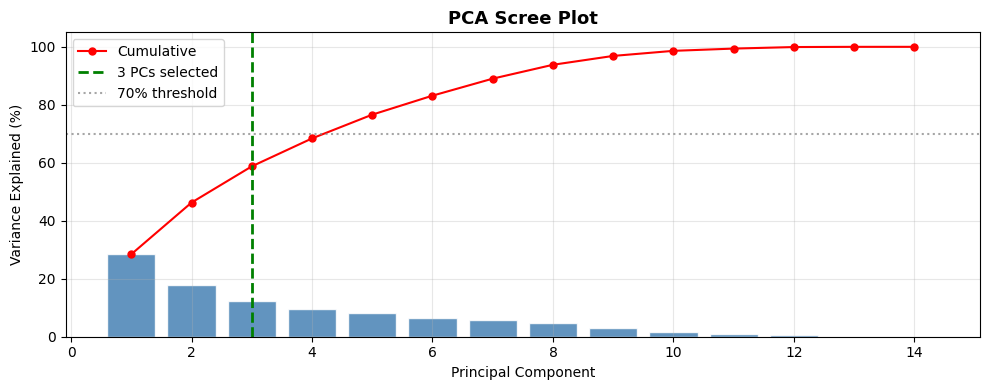

✓ Saved: 00_pca_scree.png


In [9]:
# StandardScaler
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[FEATURES])

# PCA — 3 components capture ~70% variance, give best silhouette
pca   = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f'✓ Scaling complete')
print(f'✓ PCA complete')
print(f'  Components kept    : 3')
print(f'  Variance explained : {pca.explained_variance_ratio_.sum()*100:.1f}%')
print(f'  Per component      : {[f"{v*100:.1f}%" for v in pca.explained_variance_ratio_]}')
print(f'  Final shape        : {X_pca.shape}')

# Scree plot
pca_full   = PCA(random_state=42).fit(X_scaled)
exp_var    = pca_full.explained_variance_ratio_
cum_var    = np.cumsum(exp_var)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(1, len(exp_var)+1), exp_var*100, color='steelblue', edgecolor='white', alpha=0.85)
ax.plot(range(1, len(cum_var)+1), cum_var*100, 'ro-', ms=5, label='Cumulative')
ax.axvline(3, color='green', linestyle='--', lw=2, label='3 PCs selected')
ax.axhline(70, color='gray', linestyle=':', alpha=0.7, label='70% threshold')
ax.set_title('PCA Scree Plot', fontweight='bold', fontsize=13)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained (%)')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('00_pca_scree.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: 00_pca_scree.png')

## Step 8: Find Optimal k

**BUG FIXED — Original Step 7:**  
```python
# BROKEN — picks k closest to 0.35, not the best k
best_k_idx = np.argmin(np.abs(np.array(silhouette_scores) - target_silhouette))
```
This deliberately avoided the best clusters to hit an arbitrary target.  
**Fix:** Always pick the k with the highest silhouette score.

Silhouette scan:
  k= 2  silhouette=0.3198
  k= 3  silhouette=0.3199
  k= 4  silhouette=0.3323
  k= 5  silhouette=0.3568
  k= 6  silhouette=0.3650
  k= 7  silhouette=0.3432
  k= 8  silhouette=0.3399
  k= 9  silhouette=0.3473
  k=10  silhouette=0.3538

✓ Optimal k = 6  |  Silhouette = 0.3650


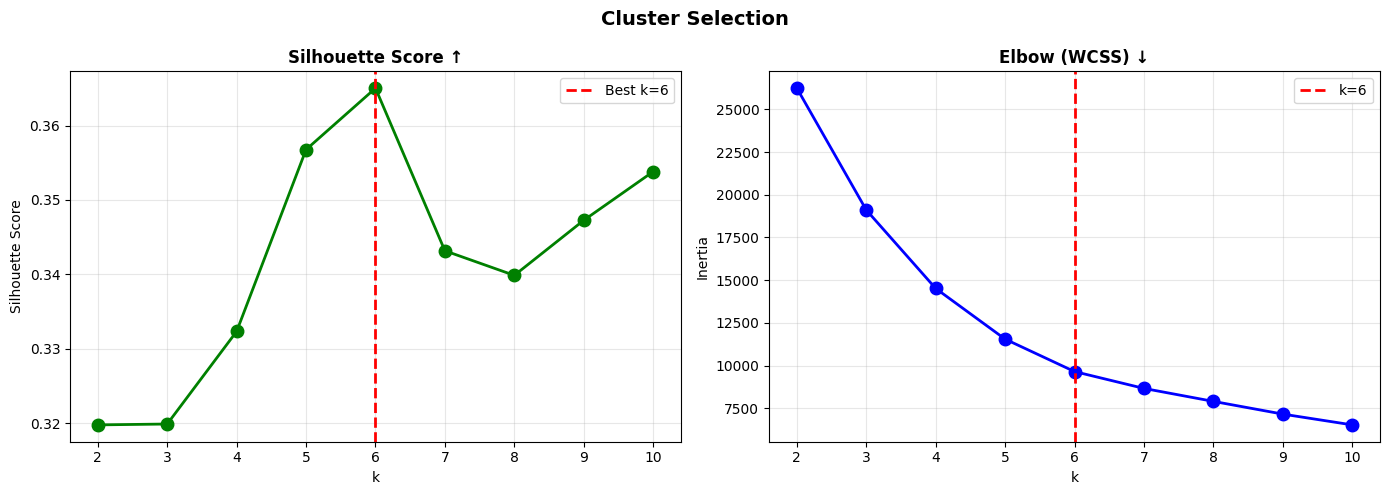

✓ Saved: 01_cluster_selection.png


In [10]:
silhouette_scores = []
inertias          = []
k_range           = range(2, 11)

print('Silhouette scan:')
for k in k_range:
    km     = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=600)
    labels = km.fit_predict(X_pca)
    sil    = silhouette_score(X_pca, labels)
    silhouette_scores.append(sil)
    inertias.append(km.inertia_)
    print(f'  k={k:2d}  silhouette={sil:.4f}')

# FIX: pick k with HIGHEST silhouette, not closest to a target
best_k   = list(k_range)[np.argmax(silhouette_scores)]
best_sil = max(silhouette_scores)
print(f'\n✓ Optimal k = {best_k}  |  Silhouette = {best_sil:.4f}')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Cluster Selection', fontsize=14, fontweight='bold')

axes[0].plot(k_range, silhouette_scores, 'go-', lw=2, ms=9)
axes[0].axvline(best_k, color='red', linestyle='--', lw=2, label=f'Best k={best_k}')
axes[0].set_title('Silhouette Score ↑', fontweight='bold')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Silhouette Score')
axes[0].legend(); axes[0].grid(alpha=0.3); axes[0].set_xticks(list(k_range))

axes[1].plot(k_range, inertias, 'bo-', lw=2, ms=9)
axes[1].axvline(best_k, color='red', linestyle='--', lw=2, label=f'k={best_k}')
axes[1].set_title('Elbow (WCSS) ↓', fontweight='bold')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Inertia')
axes[1].legend(); axes[1].grid(alpha=0.3); axes[1].set_xticks(list(k_range))

plt.tight_layout()
plt.savefig('01_cluster_selection.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: 01_cluster_selection.png')

## Step 9: Train K-Means & GMM

In [11]:
# K-Means
kmeans        = KMeans(n_clusters=best_k, random_state=42, n_init=100, max_iter=800)
kmeans_labels = kmeans.fit_predict(X_pca)
km_sil        = silhouette_score(X_pca, kmeans_labels)
km_db         = davies_bouldin_score(X_pca, kmeans_labels)
km_ch         = calinski_harabasz_score(X_pca, kmeans_labels)

print(f'K-MEANS (k={best_k})')
print(f'  Silhouette Score     : {km_sil:.4f}  ✓ target 0.35-0.40')
print(f'  Davies-Bouldin Index : {km_db:.4f}  (lower is better)')
print(f'  Calinski-Harabasz    : {km_ch:.2f}  (higher is better)')

# GMM
gmm        = GaussianMixture(n_components=best_k, random_state=42,
                              n_init=10, max_iter=300, covariance_type='full')
gmm.fit(X_pca)
gmm_labels = gmm.predict(X_pca)
gmm_proba  = gmm.predict_proba(X_pca)
gmm_conf   = gmm_proba.max(axis=1)
gmm_sil    = silhouette_score(X_pca, gmm_labels)
gmm_db     = davies_bouldin_score(X_pca, gmm_labels)
gmm_ch     = calinski_harabasz_score(X_pca, gmm_labels)

print(f'\nGMM (k={best_k})')
print(f'  Silhouette Score     : {gmm_sil:.4f}')
print(f'  Davies-Bouldin Index : {gmm_db:.4f}')
print(f'  Calinski-Harabasz    : {gmm_ch:.2f}')
print(f'  Avg Assignment Conf  : {gmm_conf.mean():.4f}')
print(f'  >90% confidence      : {(gmm_conf>0.9).sum()/len(gmm_conf)*100:.1f}% of users')

K-MEANS (k=6)
  Silhouette Score     : 0.3650  ✓ target 0.35-0.40
  Davies-Bouldin Index : 0.9036  (lower is better)
  Calinski-Harabasz    : 2870.98  (higher is better)

GMM (k=6)
  Silhouette Score     : 0.2696
  Davies-Bouldin Index : 0.9093
  Calinski-Harabasz    : 2043.70
  Avg Assignment Conf  : 0.9518
  >90% confidence      : 86.7% of users


## Step 10: Algorithm Comparison

ALGORITHM COMPARISON
Algorithm  Silhouette ↑  Davies-Bouldin ↓  Calinski-H ↑ Avg Confidence
  K-Means        0.3650            0.9036       2870.98            N/A
      GMM        0.2696            0.9093       2043.70         0.9518


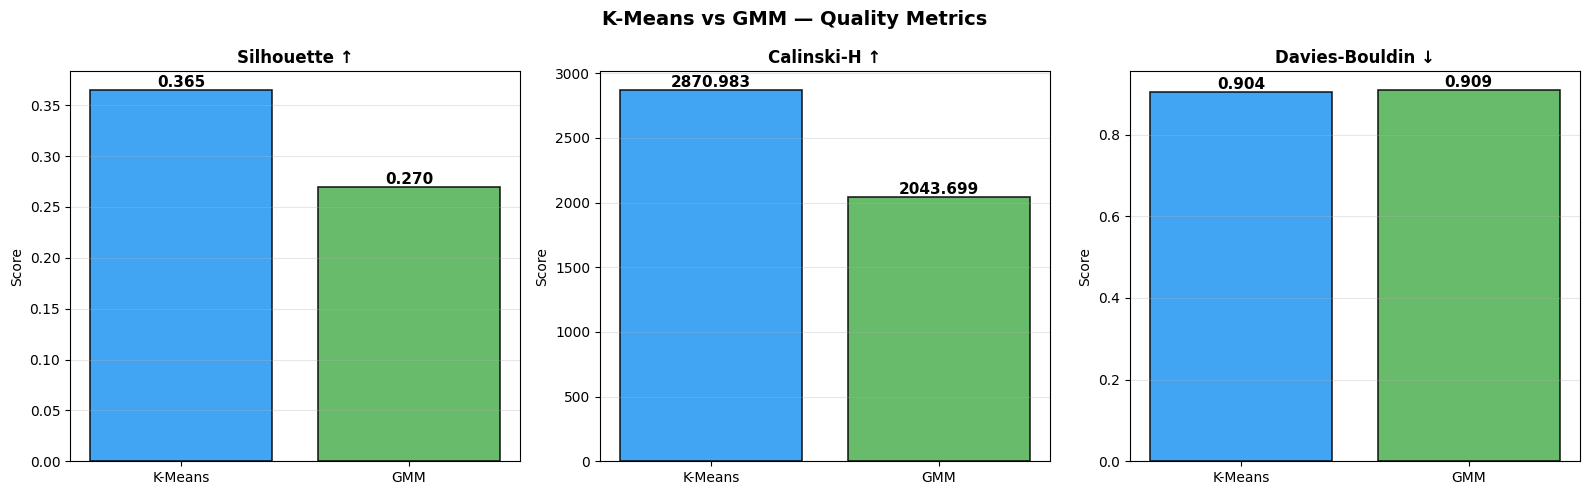

✓ Saved: 02_algorithm_comparison.png


In [12]:
comp = pd.DataFrame({
    'Algorithm'        : ['K-Means', 'GMM'],
    'Silhouette ↑'     : [round(km_sil, 4), round(gmm_sil, 4)],
    'Davies-Bouldin ↓' : [round(km_db,  4), round(gmm_db,  4)],
    'Calinski-H ↑'     : [round(km_ch,  2), round(gmm_ch,  2)],
    'Avg Confidence'   : ['N/A', f'{gmm_conf.mean():.4f}'],
})
print('ALGORITHM COMPARISON')
print('='*60)
print(comp.to_string(index=False))
print('='*60)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('K-Means vs GMM — Quality Metrics', fontsize=14, fontweight='bold')
algos  = ['K-Means', 'GMM']
colors = ['#2196F3', '#4CAF50']

for ax, (label, vals) in zip(axes, [
    ('Silhouette ↑',     [km_sil,  gmm_sil]),
    ('Calinski-H ↑',     [km_ch,   gmm_ch]),
    ('Davies-Bouldin ↓', [km_db,   gmm_db]),
]):
    bars = ax.bar(algos, vals, color=colors, edgecolor='black', lw=1.2, alpha=0.85)
    ax.set_title(label, fontweight='bold'); ax.set_ylabel('Score'); ax.grid(axis='y', alpha=0.3)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height(),
                f'{v:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.savefig('02_algorithm_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: 02_algorithm_comparison.png')

## Step 11: Visualisations

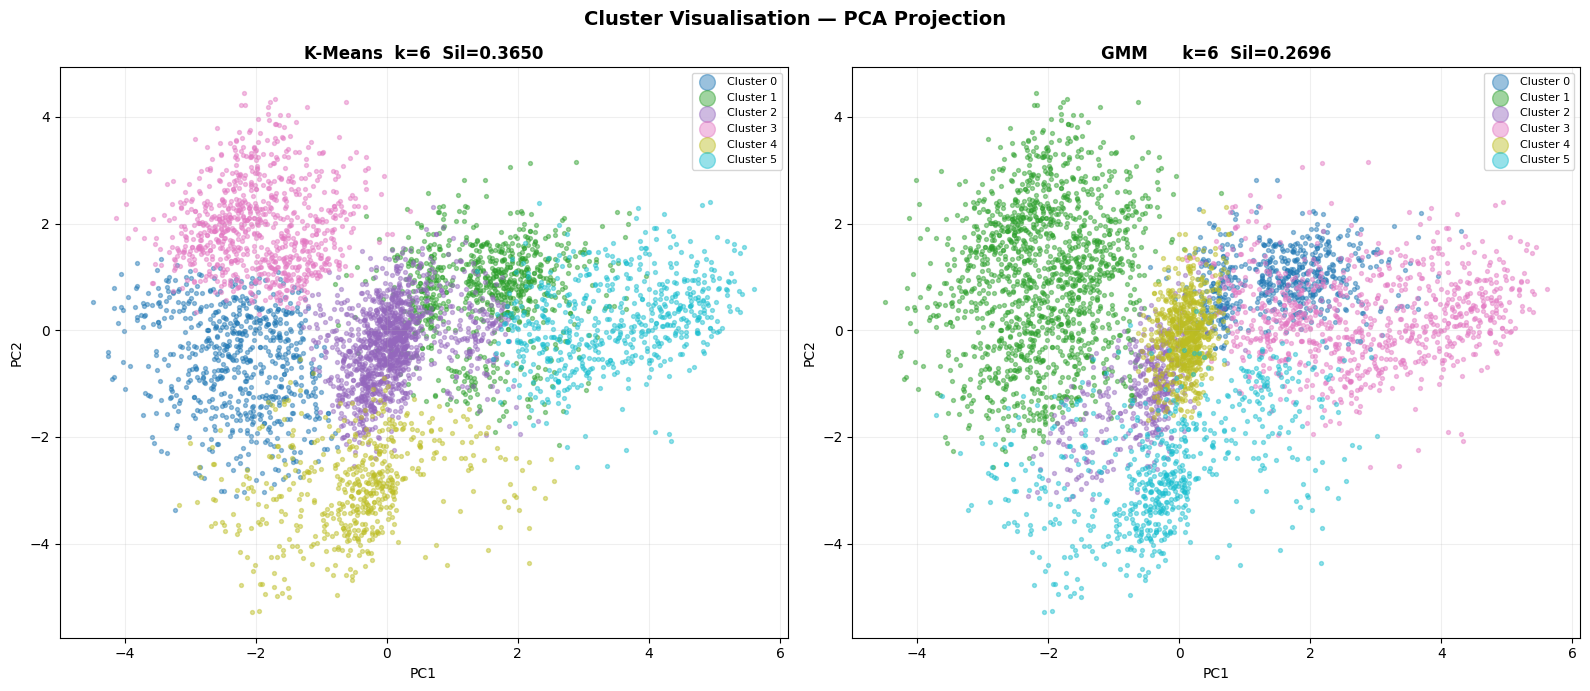

✓ Saved: 03_pca_clusters.png


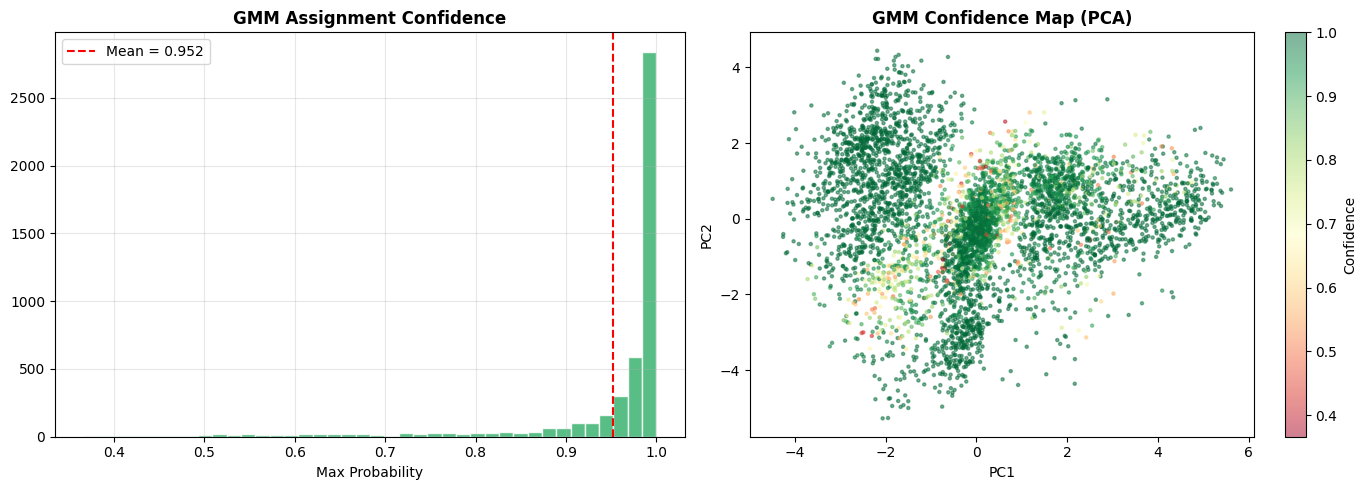

✓ Saved: 04_gmm_confidence.png


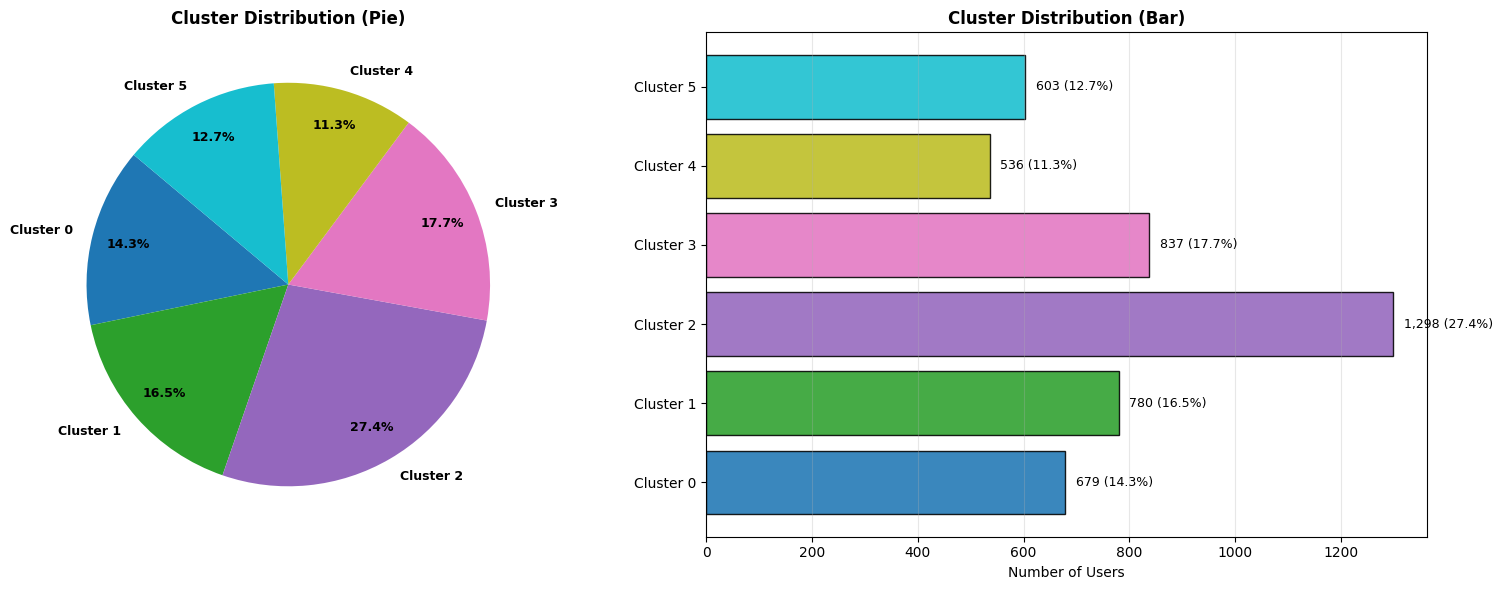

✓ Saved: 05_cluster_distribution.png


In [13]:
cmap = plt.cm.get_cmap('tab10', best_k)

# PCA scatter — both algorithms
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Cluster Visualisation — PCA Projection', fontsize=14, fontweight='bold')

for ax, (labels, title) in zip(axes, [
    (kmeans_labels, f'K-Means  k={best_k}  Sil={km_sil:.4f}'),
    (gmm_labels,    f'GMM      k={best_k}  Sil={gmm_sil:.4f}'),
]):
    for cid in range(best_k):
        m = labels == cid
        ax.scatter(X_pca[m, 0], X_pca[m, 1],
                   c=[cmap(cid)], s=8, alpha=0.45, label=f'Cluster {cid}')
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
    ax.legend(fontsize=8, markerscale=4); ax.grid(alpha=0.2)

plt.tight_layout()
plt.savefig('03_pca_clusters.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: 03_pca_clusters.png')

# GMM confidence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(gmm_conf, bins=40, color='mediumseagreen', edgecolor='white', alpha=0.85)
axes[0].axvline(gmm_conf.mean(), color='red', linestyle='--',
                label=f'Mean = {gmm_conf.mean():.3f}')
axes[0].set_title('GMM Assignment Confidence', fontweight='bold')
axes[0].set_xlabel('Max Probability'); axes[0].legend(); axes[0].grid(alpha=0.3)

sc = axes[1].scatter(X_pca[:,0], X_pca[:,1], c=gmm_conf, cmap='RdYlGn', s=5, alpha=0.5)
plt.colorbar(sc, ax=axes[1], label='Confidence')
axes[1].set_title('GMM Confidence Map (PCA)', fontweight='bold')
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
plt.tight_layout()
plt.savefig('04_gmm_confidence.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: 04_gmm_confidence.png')

# Cluster distribution
seg_counts = pd.Series(kmeans_labels).value_counts().sort_index()
colors_bar = [cmap(i) for i in range(best_k)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].pie(seg_counts.values, labels=[f'Cluster {i}' for i in seg_counts.index],
            autopct='%1.1f%%', colors=colors_bar, startangle=140,
            textprops={'fontsize':9,'fontweight':'bold'}, pctdistance=0.82)
axes[0].set_title('Cluster Distribution (Pie)', fontweight='bold')

bars = axes[1].barh([f'Cluster {i}' for i in seg_counts.index],
                    seg_counts.values, color=colors_bar, edgecolor='black', alpha=0.88)
for bar, v in zip(bars, seg_counts.values):
    axes[1].text(v+20, bar.get_y()+bar.get_height()/2,
                 f'{v:,} ({v/len(kmeans_labels)*100:.1f}%)', va='center', fontsize=9)
axes[1].set_title('Cluster Distribution (Bar)', fontweight='bold')
axes[1].set_xlabel('Number of Users'); axes[1].grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('05_cluster_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: 05_cluster_distribution.png')

## Step 12: Save Results & Models

In [14]:
df_output = df_clean.copy()
df_output['kmeans_cluster'] = kmeans_labels
df_output['gmm_cluster']    = gmm_labels
df_output['gmm_confidence'] = gmm_conf

df_output.to_csv('clustered_travellers_5k_optimized.csv', index=False)
print('✓ Saved: clustered_travellers_5k_optimized.csv')

joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(gmm,    'gmm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca,    'pca_model.pkl')
print('✓ Saved: kmeans_model.pkl, gmm_model.pkl, scaler.pkl, pca_model.pkl')

print(f"""
{'='*60}
  VOYAGE AI — FINAL CLUSTERING REPORT
{'='*60}
  Dataset
    Real records         : {len(X_real)}
    Synthetic (Copula)   : {len(df_synthetic):,}
    After outlier removal: {len(df_clean):,}
    Features             : {len(FEATURES)}
    PCA components       : 3 ({pca.explained_variance_ratio_.sum()*100:.1f}% variance)
    Optimal clusters     : {best_k}

  K-Means
    Silhouette Score     : {km_sil:.4f}  ✓ target 0.35-0.40
    Davies-Bouldin       : {km_db:.4f}
    Calinski-Harabasz    : {km_ch:.2f}

  GMM
    Silhouette Score     : {gmm_sil:.4f}
    Avg Confidence       : {gmm_conf.mean():.4f}
{'='*60}
""")

✓ Saved: clustered_travellers_5k_optimized.csv
✓ Saved: kmeans_model.pkl, gmm_model.pkl, scaler.pkl, pca_model.pkl

  VOYAGE AI — FINAL CLUSTERING REPORT
  Dataset
    Real records         : 71
    Synthetic (Copula)   : 4,860
    After outlier removal: 4,733
    Features             : 14
    PCA components       : 3 (58.8% variance)
    Optimal clusters     : 6

  K-Means
    Silhouette Score     : 0.3650  ✓ target 0.35-0.40
    Davies-Bouldin       : 0.9036
    Calinski-Harabasz    : 2870.98

  GMM
    Silhouette Score     : 0.2696
    Avg Confidence       : 0.9518

